<a href="https://colab.research.google.com/github/lamahechag/pytorch_tensorflow/blob/master/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch

Pytorch is a framework that challenge you to build a ANN almost from scratch.

This tutorial aims to explain how load non-iamges data in Pytorch, and create classification models.

1. Learn how to generate synthetic data for classification. The more complex the bidimentional patern, the larger the high dimentional transformation to find a hiperplane that separes the prolem.

1. Understand the basic components of a neural network using Pytorch: layers, foward pass, gradient calculation, update weights with any gradient desent method.

1. Do a paralallel view of TensorFlow and Pytorch.
1. Apply transformations to Loss function to trainning with imbalanced data: class weight, focal loss, etc.

__References__

https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

https://towardsdatascience.com/pytorch-basics-intro-to-dataloaders-and-loss-functions-868e86450047

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

https://cs230.stanford.edu/blog/pytorch/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# plotlib and sklearn modules
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# binary imbalanced set
X_imb, y_imb = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, weights=[0.95, 0.05], class_sep=1.5)
rng = np.random.RandomState(2)
X_imb += 2 * rng.uniform(size=X_imb.shape)

# multiclass set
X_multi, y_multi = make_classification(n_samples=10000, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=3,
                            n_clusters_per_class=1, weights=[0.33, 0.33, 0.33],
                            class_sep=0.8, random_state=7)
# non-linear separable
X_moon, y_moon = make_moons(n_samples=10000, noise=0.3, random_state=3)

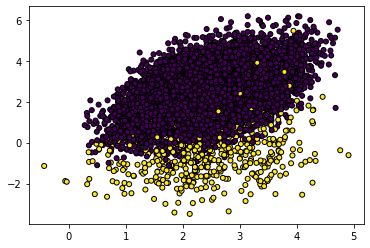

In [8]:
plt.scatter(X_imb[:, 0], X_imb[:, 1], marker='o', c=y_imb,
            s=25, edgecolor='k')

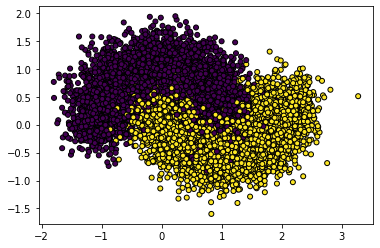

In [9]:
plt.scatter(X_moon[:, 0], X_moon[:, 1], marker='o', c=y_moon,
            s=25, edgecolor='k')

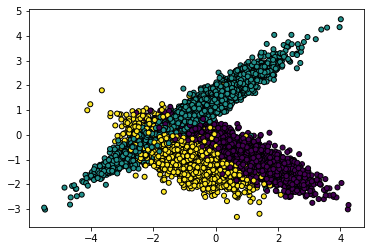

In [10]:
plt.scatter(X_multi[:, 0], X_multi[:, 1], marker='o', c=y_multi,
            s=25, edgecolor='k')

# Data loader

We create a custom dataset class to iterate our data in the dataloader from Pytorch.

`trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))`

Then we use `DataLoader` to allow auto batching. The function `loader_data()` gather all the pipeline to load tha data in a Pytorch tensor.

In [6]:
class trainData(Dataset):  
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data   
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

  
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
    def __getitem__(self, index):
        return self.X_data[index]
    def __len__ (self):
        return len(self.X_data)

def loader_data(X, y, BATCH_SIZE=500):        
    # create function that recive the X and y, batch and returns: train_loader and test_loader.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                        random_state=69, stratify=y_imb)
    train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    test_data = testData(torch.FloatTensor(X_test))
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=100)
    return train_loader, test_loader, y_test

# Pytorch Model

To build a model in Pytorch, you should define a `Class`. The class has two  parts:

1. `__init__` defines the different elements of calculation, like: hidden layers, activation functions, dropouts, etc.

1. `foward` method where you define how the input going through each calculation element.

You will see that in the output layer for the binary classifiers there is not `sigmoid` function in the output layer, this is because in Pytorch it can be include in the loss function that will be defined later.

In [23]:
class LogisClassifier(nn.Module):
    def __init__(self, num_input=2):
        super(LogisClassifier, self).__init__()
        self.num_input = num_input
        # Number of input features
        self.layer_1 = nn.Linear(self.num_input, 1)     
    def forward(self, inputs):
        x = self.layer_1(inputs)    
        return x

class binaryClassification(nn.Module):
    def __init__(self, num_input=2):
        super(binaryClassification, self).__init__()
        self.num_input = num_input
        # Number of input features
        self.layer_1 = nn.Linear(self.num_input, 120) 
        self.layer_2 = nn.Linear(120, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(120)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)      
        return x

class Multiclass(nn.Module):  
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Softmax(dim=1)

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

# Training loop

In a neural network the process of learning is as follow: calculate the output, calculate the gradient, do the backward pass and update the weights.

Within the training loop, you should do this in each iteration.
1. reset gradient to zero.
1. perform backward step.
1. update parameters.

Also before to measure accuracy and evaluate should be define in Pytorch operations.

In [24]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def eval_testdata(model, test_loader):
    y_pred_list = []
    model.eval()
    # this 'with' is to evaluate without a gradient step.
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list += y_pred_tag.cpu().numpy().squeeze().tolist()
    return y_pred_list

def train_model(model, criterion, optimizer, train_loader, EPOCHS, test_loader, y_test):
    model.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        y_pred_test = eval_testdata(model, test_loader)
        eval_acc = round(accuracy_score(y_true=y_test, y_pred=y_pred_test), 2)
        eval_f1 = round(f1_score(y_true=y_test, y_pred=y_pred_test),2)
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Acc_eval: {eval_acc} | f1_eval: {eval_f1}')

# Declare model and train

We have defined a training loop, but we need a loss function and an optimizer to perform gradient desent step.

In the first line the data are loaded, followed by the model declaration and send to the `GPU` device in this case.

## First experiment: Logistic classifier.

In [25]:
train_loader, test_loader, y_test = loader_data(X_moon, y_moon, BATCH_SIZE=10)
model = LogisClassifier()
model.to(device)
# define loss function
criterion = nn.BCEWithLogitsLoss()
LEARNING_RATE = 0.001
# define gradient decent optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

# now train(fit) the model
EPOCHS = 100
train_model(model, criterion, optimizer, train_loader, EPOCHS, test_loader, y_test)

LogisClassifier(
  (layer_1): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 001: | Loss: 0.65585 | Acc: 53.806 | Acc_eval: 0.7 | f1_eval: 0.7
Epoch 002: | Loss: 0.51862 | Acc: 73.881 | Acc_eval: 0.78 | f1_eval: 0.78
Epoch 003: | Loss: 0.45027 | Acc: 78.746 | Acc_eval: 0.81 | f1_eval: 0.81
Epoch 004: | Loss: 0.41158 | Acc: 80.761 | Acc_eval: 0.82 | f1_eval: 0.82
Epoch 005: | Loss: 0.38718 | Acc: 82.030 | Acc_eval: 0.83 | f1_eval: 0.83
Epoch 006: | Loss: 0.37097 | Acc: 82.985 | Acc_eval: 0.84 | f1_eval: 0.84
Epoch 007: | Loss: 0.35982 | Acc: 83.582 | Acc_eval: 0.85 | f1_eval: 0.85
Epoch 008: | Loss: 0.35223 | Acc: 84.104 | Acc_eval: 0.85 | f1_eval: 0.85
Epoch 009: | Loss: 0.34708 | Acc: 84.433 | Acc_eval: 0.85 | f1_eval: 0.85
Epoch 010: | Loss: 0.34370 | Acc: 84.731 | Acc_eval: 0.85 | f1_eval: 0.85
Epoch 011: | Loss: 0.34149 | Acc: 84.806 | Acc_eval: 0.86 | f1_eval: 0.86
Epoch 012: | Loss: 0.34005 | Acc: 84.985 | Acc_eval: 0.86 | f1_eval: 0.86
Epoch 013: | Loss: 0.33915 | Acc:

3300